In [ ]:
import pandas as pd
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
import helper
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A

from torch.utils.data import DataLoader, Dataset
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
transform = transforms.Compose(
    [transforms.Resize((256,256)),transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


transform_augmentation = transforms.Compose(
    [transforms.Resize((256,256)),
     #transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomRotation(degrees=(-45, 45)),
     #transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#batch_size = 4

dataset_train = datasets.ImageFolder('/content/drive/My Drive/BD/Train', transform=transform)

dataset_train_augmentation = dataset_train + datasets.ImageFolder('/content/drive/My Drive/BD/Train', transform=transform_augmentation)


dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=10, shuffle=True)


dataset_test = datasets.ImageFolder('/content/drive/My Drive/BD/Test', transform=transform)

dataset_test_augmentation = dataset_test + datasets.ImageFolder('/content/drive/My Drive/BD/Train', transform=transform_augmentation)

dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=10, shuffle=False)

classes = ('Beavis', 'Butthead')

In [ ]:
# get some random training images
dataiter = iter(dataloader_train)
images, labels = dataiter.next()
# show images
#imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

In [ ]:
images, labels = next(iter(dataloader_train))
#helper.plt.imshow(images[0], normalize=False)

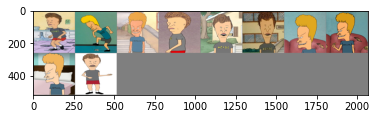

tensor([1, 0, 0, 1, 1, 1, 0, 0, 0, 1])


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloader_train)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print(labels)

In [ ]:
class net(nn.Module):
  def __init__(self) -> None:
      super().__init__()

      self.conv1 = nn.Conv2d(3, 16, 3, padding = 1) #out: 16*256*256
      self.batch1 = nn.BatchNorm2d(16)
      self.maxpool1 = nn.MaxPool2d(2,2) #out: 16*128*128

      self.conv2 = nn.Conv2d(16,32,3, padding = 1) #out: 32*128*128
      self.batch2 = nn.BatchNorm2d(32)
      #self.maxpool2 = nn.MaxPool2d(3,3)
      
      self.softmax = nn.Softmax(dim=1)

      self.linear1 = nn.Linear(32*64*64, 8*16*16) #524.288
      self.linear2 = nn.Linear(8*16*16, 2*4*4)
      self.linear3 = nn.Linear(2*4*4, 2)

  def forward(self,x):

    x = self.maxpool1(F.relu(self.conv1(x)))
    x = self.batch1(x)

    x = self.maxpool1(F.relu(self.conv2(x)))
    x = self.batch2(x)

    x = torch.flatten(x,1)  #torch.view
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.softmax(x)

    return x

Net = net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(Net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#x = Net(torch.rand([1,3,256,256]))
#x.shape

In [ ]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader_train, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = Net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 10 == 4:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 5:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,     5] loss: 0.654
[1,    15] loss: 0.861
[2,     5] loss: 0.316
[2,    15] loss: 0.636
[3,     5] loss: 0.315
[3,    15] loss: 0.633
[4,     5] loss: 0.315
[4,    15] loss: 0.628
[5,     5] loss: 0.315
[5,    15] loss: 0.628
Finished Training


In [ ]:
PATH = './Beavis&Butthead_net.pth'
torch.save(Net.state_dict(), PATH)

In [ ]:
dataiter = iter(dataloader_test)
images, labels = dataiter.next()

In [ ]:
Net = net()
Net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = Net(images)

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloader_test:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = Net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy is {100 * correct // total} %')

Accuracy is 95 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in dataloader_test:
        images, labels = data
        outputs = Net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Beavis is 100.0 %
Accuracy for class: Butthead is 90.9 %
